<a href="https://colab.research.google.com/github/tanglan7857/-/blob/master/3_6Predicting%20house%20prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import boston_housing  
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [0]:
#将每个特征标准化
mean = train_data.mean(axis=0) 
train_data -= mean 
std = train_data.std(axis=0) 
train_data /= std  
test_data -= mean 
test_data /= std

In [0]:
#构建网络
from keras import models 
from keras import layers  
def build_model():     
    model = models.Sequential()      
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))     
    model.add(layers.Dense(64, activation='relu'))     
    model.add(layers.Dense(1))     
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])    
    return model

In [11]:
#K折验证
#为了在调节网络参数（比如训练的轮数）的同时对网络进行评估，将数据划分为训练集和验证集
#实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于 K 个验证分数的平均值
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
all_scores 

[2.1065537126937715, 2.433473853781672, 2.5015999621684006, 2.8974400699728786]

In [13]:
#保存每折的验证结果
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

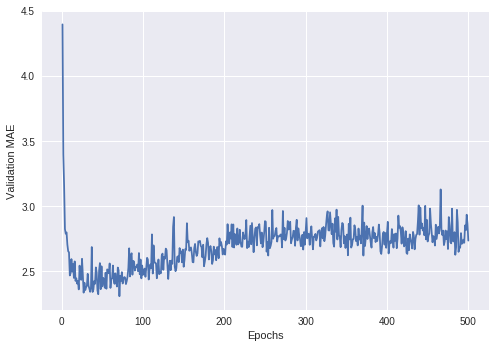

In [17]:
#绘制验证分数
import matplotlib.pyplot as plt  
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

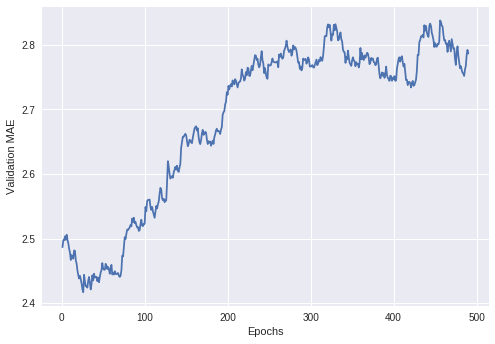

In [19]:
#绘制验证分数(删除前十个点)
def smooth_curve(points, factor=0.9):   
  smoothed_points = []   
  for point in points:     
      if smoothed_points:       
        previous = smoothed_points[-1]       
        smoothed_points.append(previous * factor + point * (1 - factor))     
      else:      
        smoothed_points.append(point)   
  return smoothed_points  
smooth_mae_history = smooth_curve(average_mae_history[10:])  
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [22]:
#训练最终模型
model = build_model()
model.fit(train_data, train_targets,epochs=40, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [23]:
test_mae_score

3.02064567453721